# YOLO transfer learning
- 링크 : https://github.com/deep-diver/Soccer-Ball-Detection-YOLOv2/blob/master/YOLOv2-Train.ipynb

In [1]:
%matplotlib inline
## path 바꾸기 -> 한번만 실행
import os
print (os.getcwd()) #현재 디렉토리
darkflow_path = os.path.join(os.getcwd(), 'darkflow')
#디렉토리를 darkflow 안으로 바꿔줌
os.chdir(darkflow_path)
print (os.getcwd())

c:\OCR-SizeTable\OCR_test
c:\OCR-SizeTable\OCR_test\darkflow


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from darkflow.net.build import TFNet
import cv2

# gpu issue
- `Error : Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.`
- [링크참조](https://eehoeskrap.tistory.com/290)

In [2]:
# issue 해결
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# .cfg 변경
- 기존 모델을 자신의 데이터 세트에 맞게 조정해야함
- YOLOv2는  80개였나? class를 구분하는데 내가 사용할 model은 sizetable하나만 찾으면 되게때문에 그에 맞게 .cfg파일 수정
- darkflow/cfg/yolo.cfg를 복사해서 다른이름으로 저장하도록함
    - size-yolo.cfg
    - 그리고 .cfg파일 수정
        - [region]의 classes와 
        - 바로위의 [convoluntional]의 fiters를 바꿔줌
            - filters = [classes + 5] * 5
            
```bash
[convolutional]
size=1
stride=1
pad=1
filters=30 # 이부분 수정
activation=linear


[region]
anchors =  0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828
bias_match=1
classes=1 # 이부분 수정
coords=4
num=5
softmax=1
jitter=.3
rescore=1

object_scale=5
noobject_scale=1
class_scale=1
coord_scale=1

absolute=1
thresh = .1
random=1

```


# labels 변경
- darkflow/labels를 자신이 분류하려는 클래스 label로 수정
- 기존의 labels다 지우고 `table`을 넣어주도록 함

# Pre-trained Weights download
- [here](https://drive.google.com/drive/folders/0B1tW_VtY7onidEwyQ2FtQVplWEU)여기서 `yolo.weights` 다운로드
- 그리고 darkflow의 `bin`폴더에 위치 시킴
    - 없으면 bin폴더 생성

In [3]:
options = {"model": "cfg/size-yolo.cfg", # 어떤 model 쓸지
           "load": "bin/yolo.weights", # pre-trained weight file
           "batch": 2, # 짝수로 batch 설정해줘야함 1로 설정하면 concat error 났었음
           "epoch": 10,
           "train": True, # train시키는거면 True
           "gpu": 1.0, # gpu 할당, 0~.1.0
           "annotation": "../data/annotations/", # annotation 위치
           "dataset": "../data/dataset"} #image dataset 위치

## 이어서 학습하려면

In [5]:
options = {"model": "cfg/size-yolo.cfg", # 어떤 model 쓸지
           "load": -1, # checkpoint를 weight로 load한다
           "batch": 2, # 짝수로 batch 설정해줘야함 1로 설정하면 concat error 났었음
           "epoch": 1,
           "lr": 1e-6,
           "train": True, # train시키는거면 True
           #"gpu": 1.0, # gpu 할당, 0~.1.0
           "annotation": "../data/annotations/", # annotation 위치
           "dataset": "../data/dataset"} #image dataset 위치}

# model build
- 설정된 option으로 darkflow의 [tfnet](https://github.com/thtrieu/darkflow/blob/master/darkflow/net/build.py)으로 model build

In [6]:
tfnet = TFNet(options, darknet=None)

Parsing cfg/size-yolo.cfg
Loading None ...
Finished in 0.0009999275207519531s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
Instructions for updating:
Colocations handled automatically by placer.
       |        | input                            | (?, 608, 608, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 608, 608, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 304, 304, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 304, 304, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 152, 152, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Init  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 152, 152, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 76, 76, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 76,

# 앞의 특징 뽑는 layer 묶고 뒤의 layer만 따로 학습

- `darkflow/darkflow/net/build.py`의 59번째 줄의 self.ntrain을 수정해줌
```python
		if darknet is None:	
			darknet = Darknet(FLAGS)
			self.ntrain = len(darknet.layers) # 마지막 2개의 layer만 수정되게 하기위해 2를 넣어서 바꿔줌
```
- TFNet에 option값을 주고 생성했을때 인스턴스의 ntrain을 찍어봤는데 분명 수정했는데 바뀌지 않는다면
- conda를 전부 종료하고 다시 켜보거나 그래도 안되면 darkflow 재설치

In [5]:
tfnet.ntrain

2

In [6]:
tfnet.train()


cfg/size-yolo.cfg parsing ../data/annotations/
Parsing for ['table'] 
[====================>]100%  screen_shot_1_3.xml
Statistics:
table: 23
Dataset size: 21
Dataset of 21 instance(s)
Training statistics: 
	Learning rate : 1e-05
	Batch size    : 2
	Epoch number  : 10
	Backup every  : 2000
step 1 - loss 224.14041137695312 - moving ave loss 224.14041137695312
step 2 - loss 221.1070556640625 - moving ave loss 223.83707580566409


AttributeError: 'NoneType' object has no attribute 'shape'

# 예측하기 위한 model option 설정
- 최근 ckpt는 `"load" : -1`
- 특정 ckpt는 ckpt폴더내의 해당 ckpt의 숫자를 넣어주면 됨
    - size-yolo-1000 => `"load" : 1000`

In [8]:
# model은 사용하는 cfg model
options = {"model" : "cfg/size-yolo.cfg",
           "load" : -1} # 최신 checkpoint를 load하려면 -1

In [9]:
tfnet2 = TFNet(options)

Parsing cfg/size-yolo.cfg
Loading None ...
Finished in 0.0009999275207519531s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
       |        | input                            | (?, 608, 608, 3)
 Init  |  Nope  | conv 3x3p1_1  +bnorm  leaky      | (?, 608, 608, 32)
 Load  |  Nope  | maxp 2x2p0_2                     | (?, 304, 304, 32)
 Init  |  Nope  | conv 3x3p1_1  +bnorm  leaky      | (?, 304, 304, 64)
 Load  |  Nope  | maxp 2x2p0_2                     | (?, 152, 152, 64)
 Init  |  Nope  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Init  |  Nope  | conv 1x1p0_1  +bnorm  leaky      | (?, 152, 152, 64)
 Init  |  Nope  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Nope  | maxp 2x2p0_2                     | (?, 76, 76, 128)
 Init  |  Nope  | conv 3x3p1_1  +bnorm  leaky      | (?, 76, 76, 256)
 Init  |  Nope  | conv 1x1p0_1  +bnorm  leaky      | (?, 76, 7

# check point load
- TFNet에서 option에 지정한 검사점에서 미리 훈련 된 매개 변수가 로드 됨

In [10]:
tfnet2.load_from_ckpt()

Loading from ./ckpt/size-yolo-20000
INFO:tensorflow:Restoring parameters from ./ckpt/size-yolo-20000


In [11]:
%%time
import pprint as pp

file_path = '../data/dataset'
original_img = cv2.imread(os.path.join(file_path, 'img18_6.jpg'))
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
# json 형태로 rect값 return
results = tfnet2.return_predict(original_img)
print(results)

[{'label': 'table', 'confidence': 0.45337456, 'topleft': {'x': 8, 'y': 6}, 'bottomright': {'x': 32, 'y': 34}}, {'label': 'table', 'confidence': 0.47732675, 'topleft': {'x': 0, 'y': 0}, 'bottomright': {'x': 59, 'y': 63}}, {'label': 'table', 'confidence': 0.45532322, 'topleft': {'x': 0, 'y': 0}, 'bottomright': {'x': 90, 'y': 132}}, {'label': 'table', 'confidence': 0.0, 'topleft': {'x': 0, 'y': 0}, 'bottomright': {'x': 183, 'y': 93}}, {'label': 'table', 'confidence': 0.0, 'topleft': {'x': 0, 'y': 0}, 'bottomright': {'x': 223, 'y': 206}}, {'label': 'table', 'confidence': 0.453372, 'topleft': {'x': 49, 'y': 6}, 'bottomright': {'x': 73, 'y': 34}}, {'label': 'table', 'confidence': 0.47731215, 'topleft': {'x': 22, 'y': 0}, 'bottomright': {'x': 100, 'y': 63}}, {'label': 'table', 'confidence': 0.0, 'topleft': {'x': 0, 'y': 0}, 'bottomright': {'x': 264, 'y': 206}}, {'label': 'table', 'confidence': 0.453372, 'topleft': {'x': 90, 'y': 6}, 'bottomright': {'x': 114, 'y': 34}}, {'label': 'table', 'con

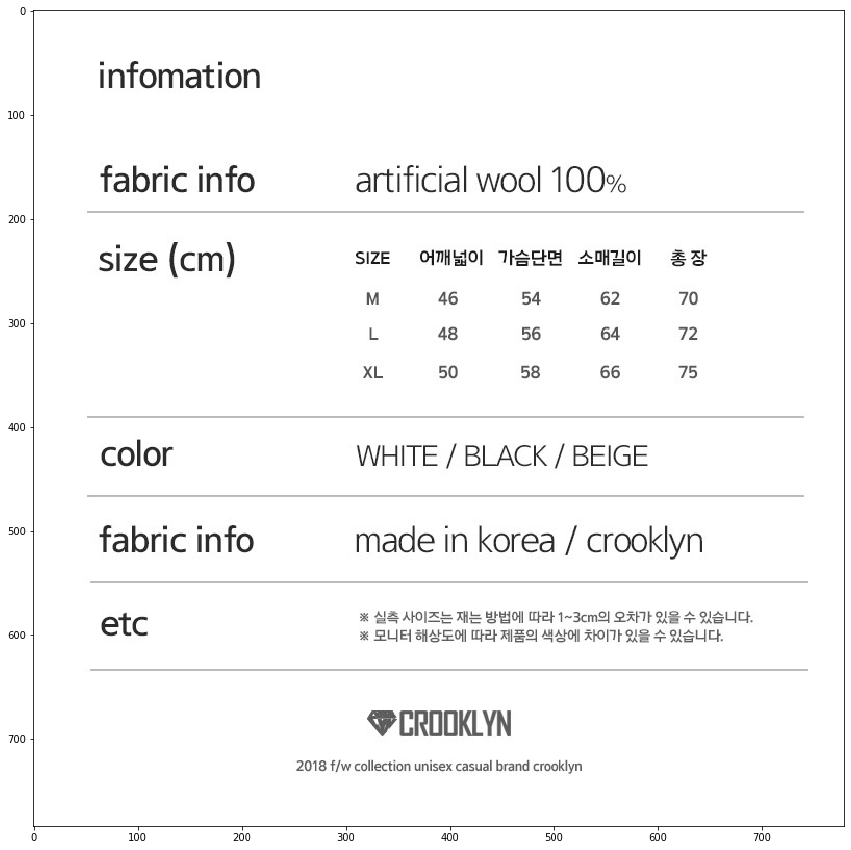

In [12]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(original_img)

In [13]:
# from darkflow.net.build import TFNet
# import cv2

# options = {"model": "cfg/yolo.cfg", "load": "bin/yolo.weights", "threshold": 0.1}

# tfnet = TFNet(options)

# imgcv = cv2.imread("./sample_img/sample_dog.jpg")
# result = tfnet.return_predict(imgcv)
# print(result)
def boxing(original_img , predictions):
    newImage = np.copy(original_img)

    for result in predictions:
        top_x = result['topleft']['x']
        top_y = result['topleft']['y']

        btm_x = result['bottomright']['x']
        btm_y = result['bottomright']['y']

        confidence = result['confidence']
        # confidence는 클래스일 확률 
        label = result['label'] + " " + str(round(confidence, 5))
        
        if confidence > 0.48074:
            newImage = cv2.rectangle(newImage, (top_x, top_y), (btm_x, btm_y), (255,0,0), 3)
            newImage = cv2.putText(newImage, label, (top_x, top_y-5), cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.8, (0, 230, 0), 1, cv2.LINE_AA)
        
    return newImage

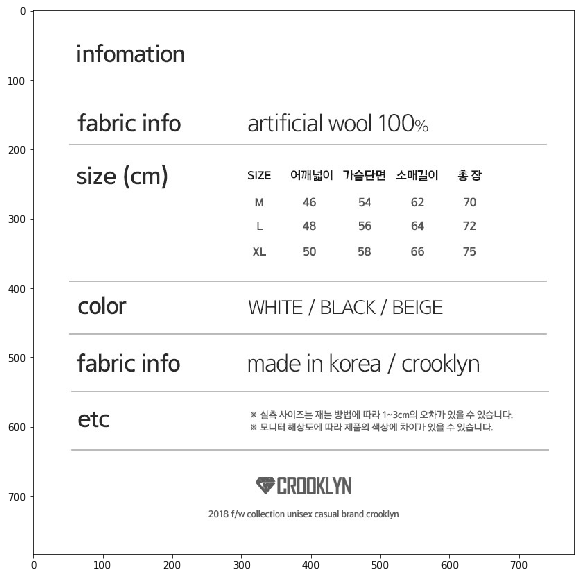

In [14]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(boxing(original_img, results))

# 특정 dir의 image들 모두 예측하기

In [15]:
%%time
data_path = '../data/dataset'
predict_img = []
file_list = []
for idx, img in enumerate(os.listdir(data_path)):
    if '.jpg' in img or '.png' in img:
        if idx % 10 == 0:
            print(f'{idx}...')
        file_list.append(img)
        img_path = os.path.join(data_path, img)
        img_ = cv2.imread(img_path)
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        results = tfnet2.return_predict(img_)
        predict_img.append(boxing(img_, results))

0...
10...
20...
30...
Wall time: 39.7 s


In [16]:
len(predict_img)

40

C:\ProgramData\Anaconda3\envs\tmh_env\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


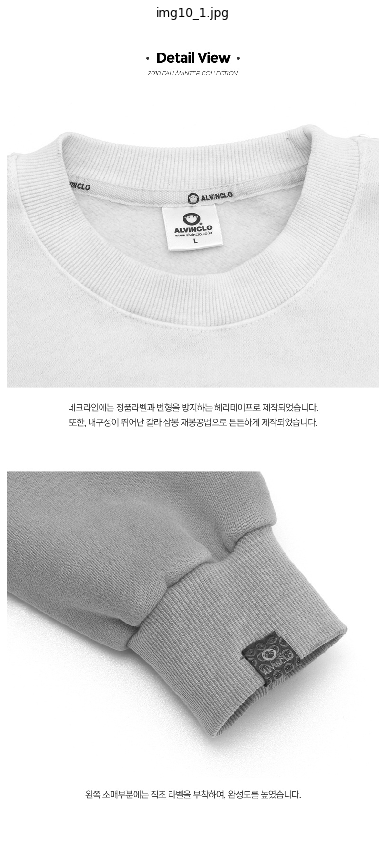

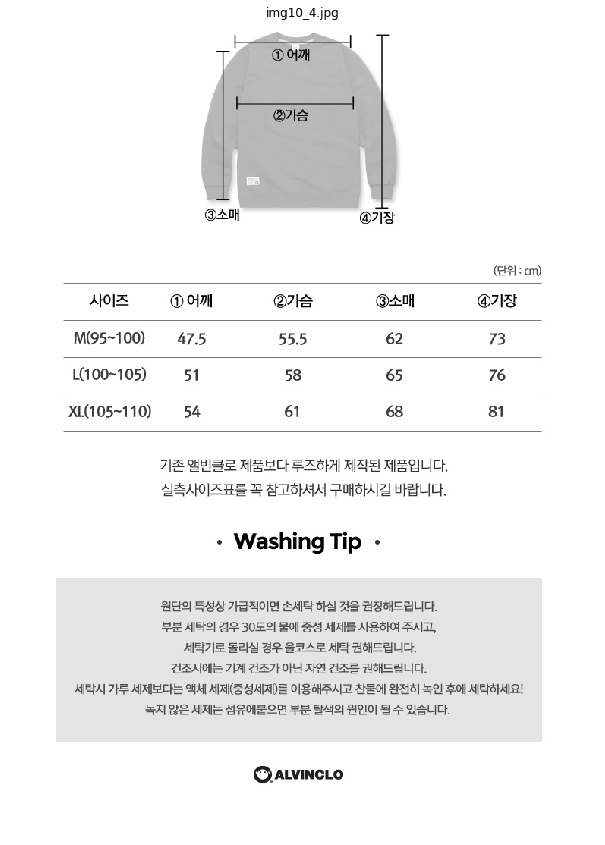

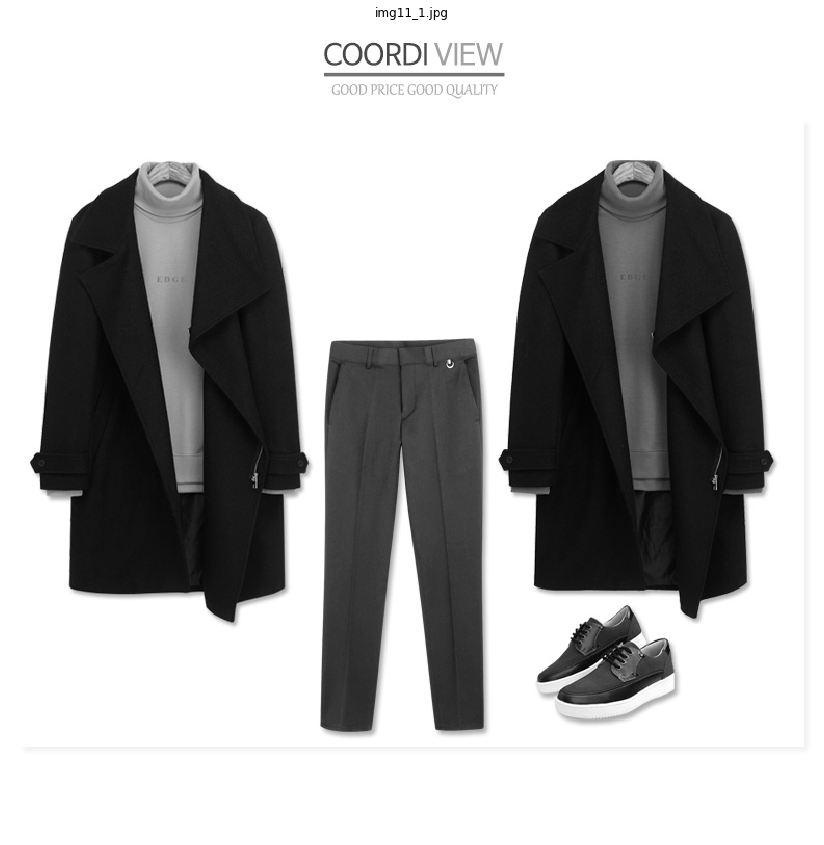

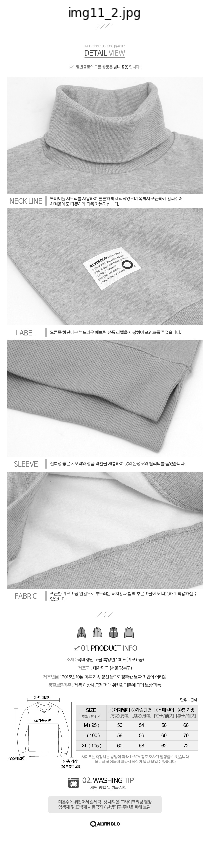

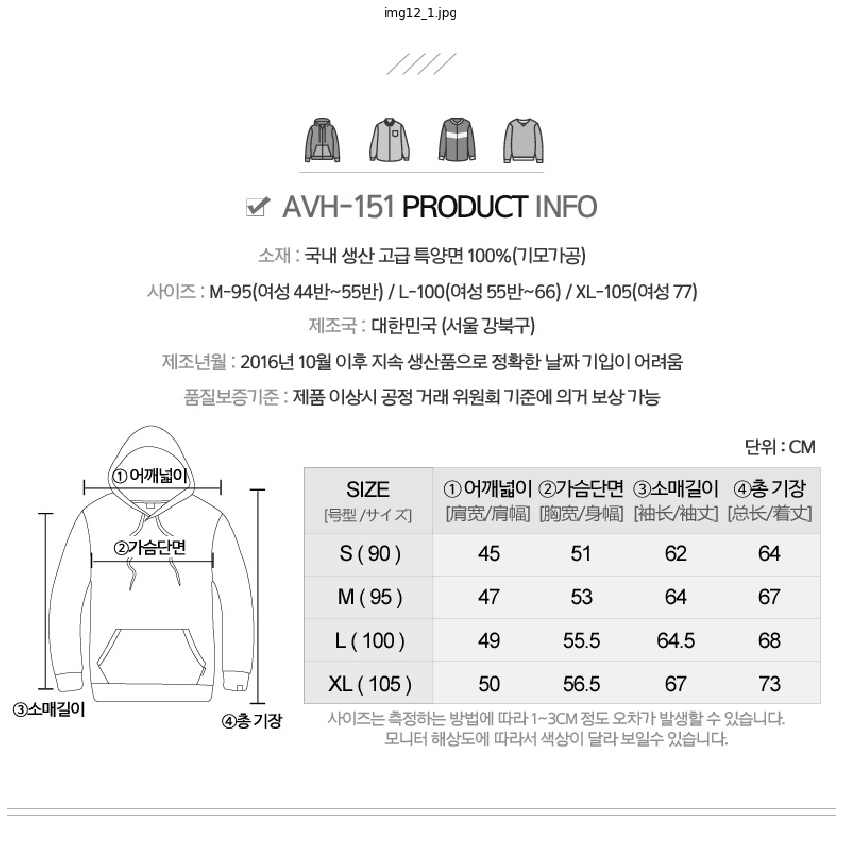

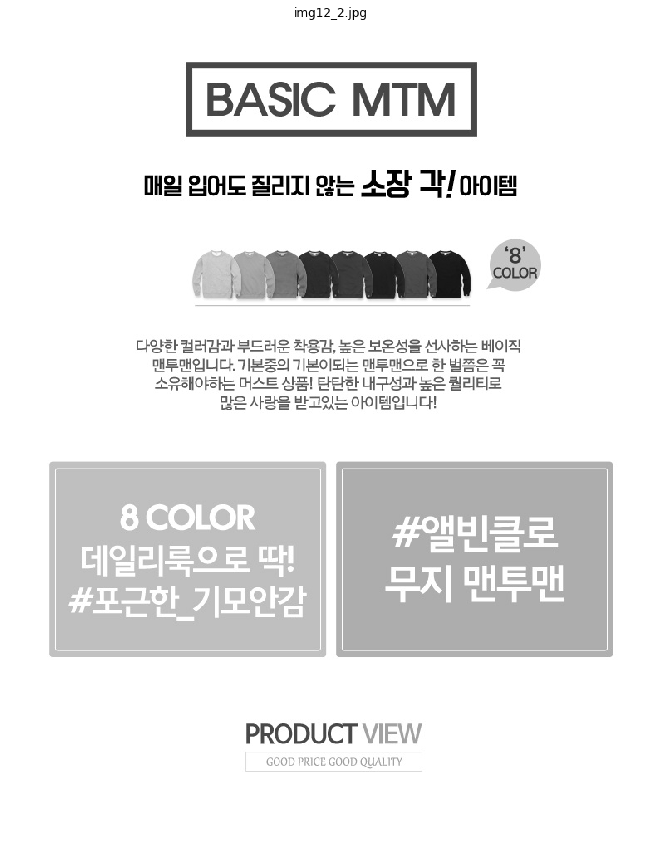

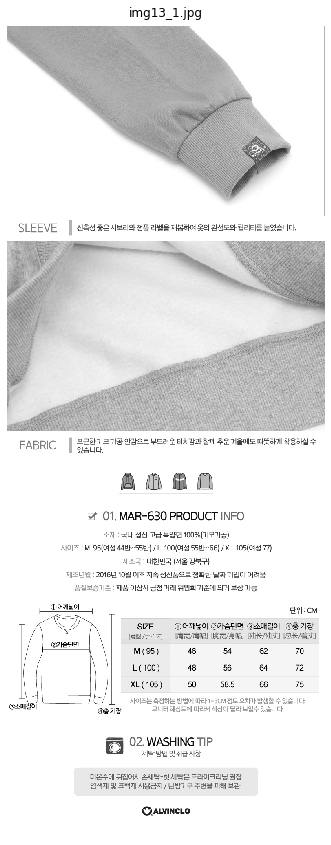

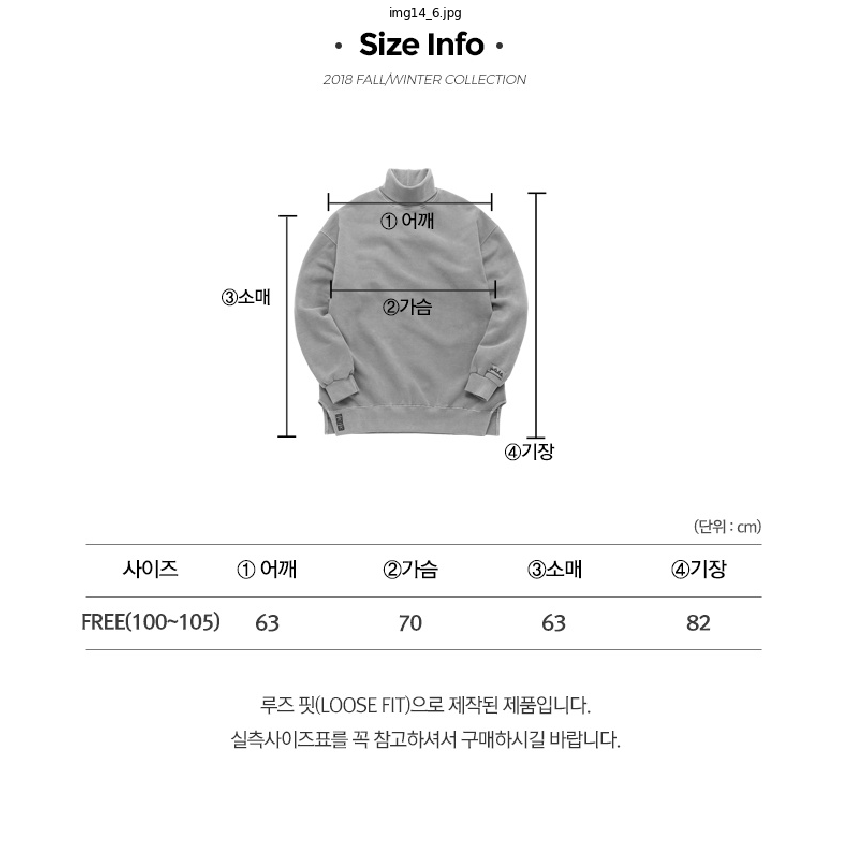

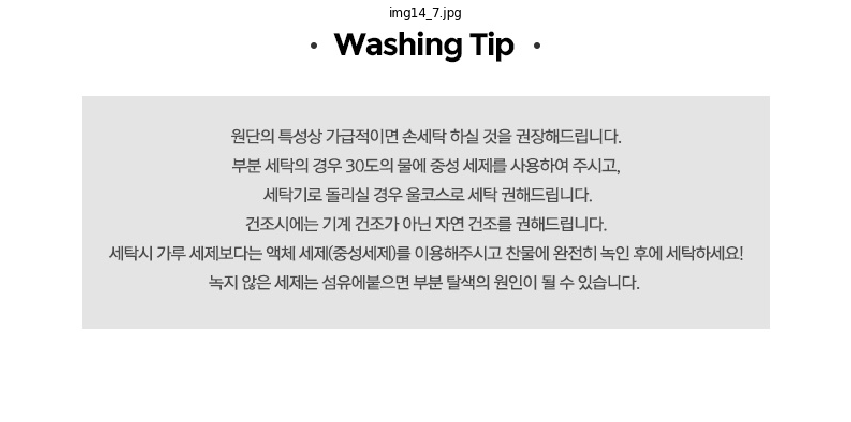

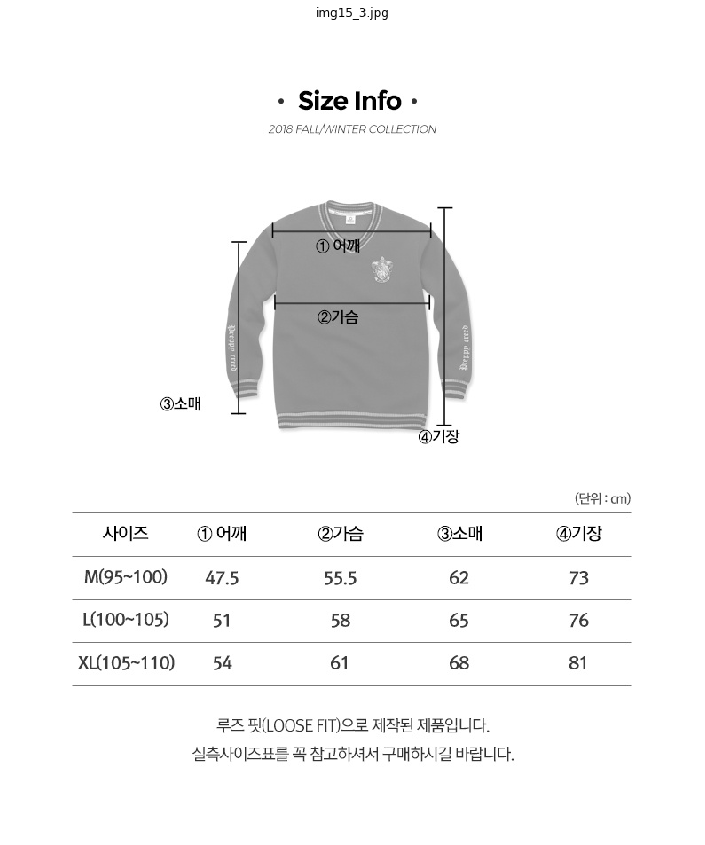

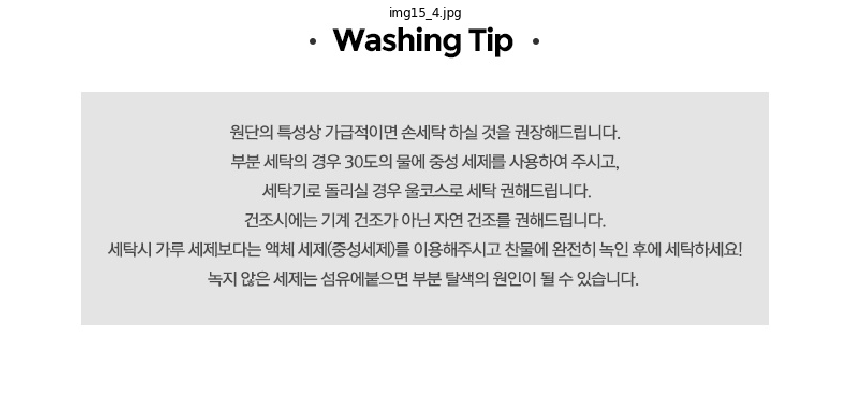

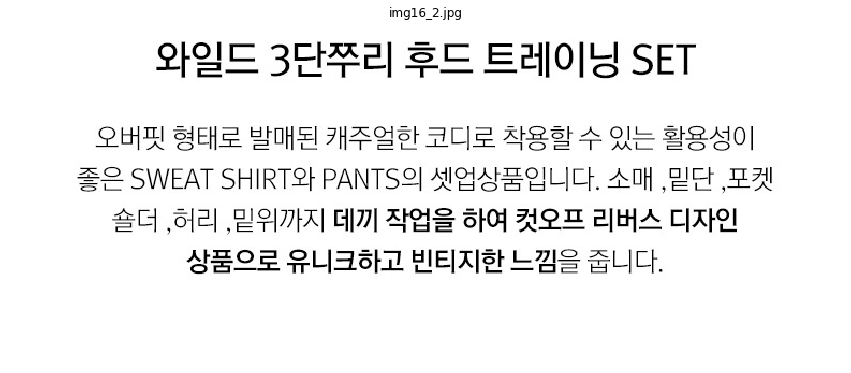

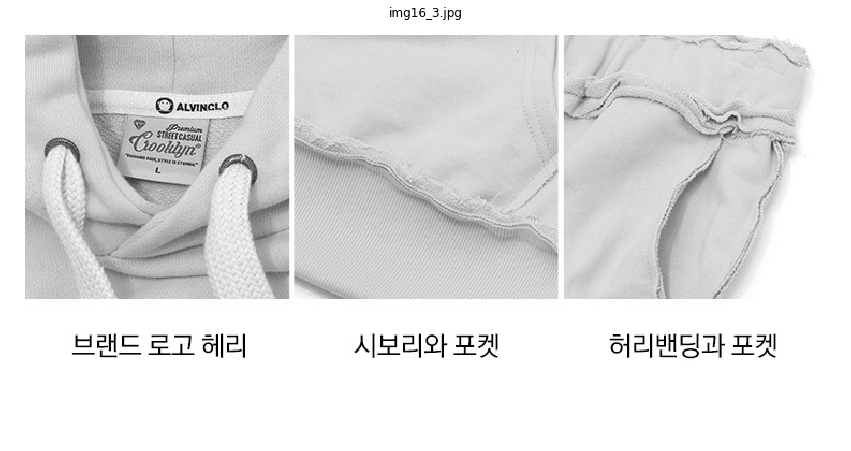

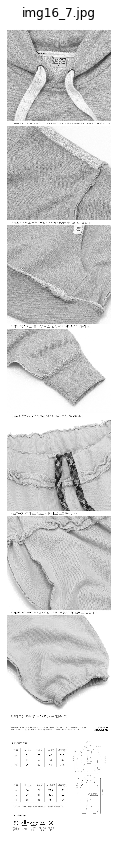

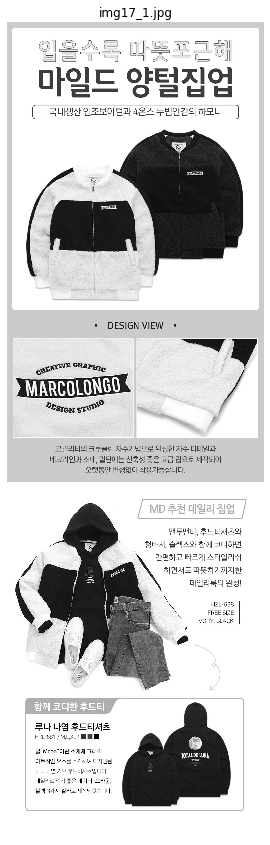

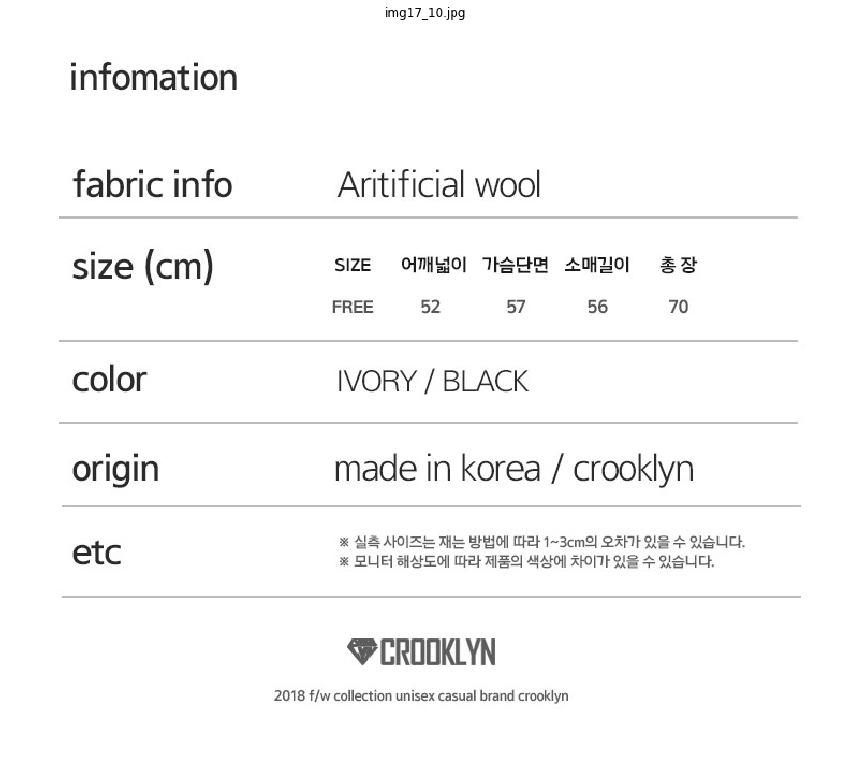

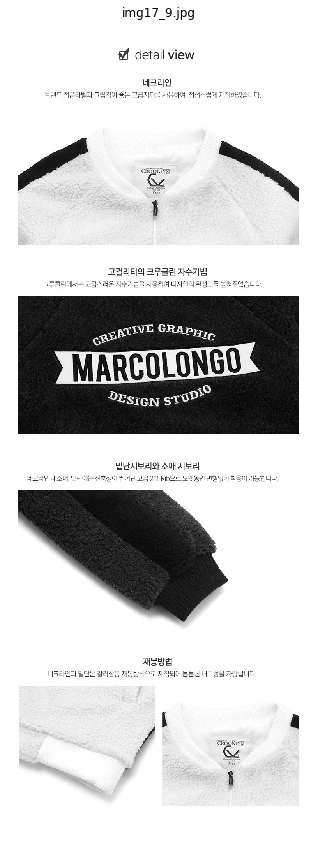

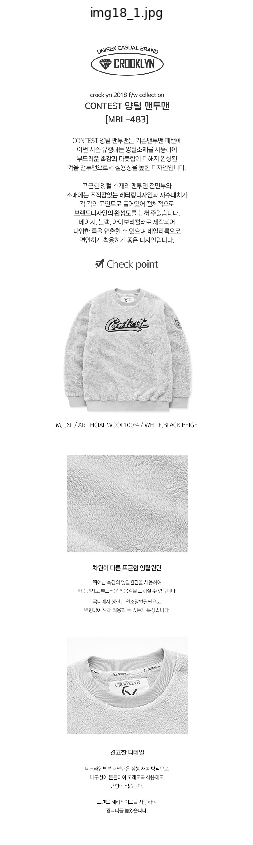

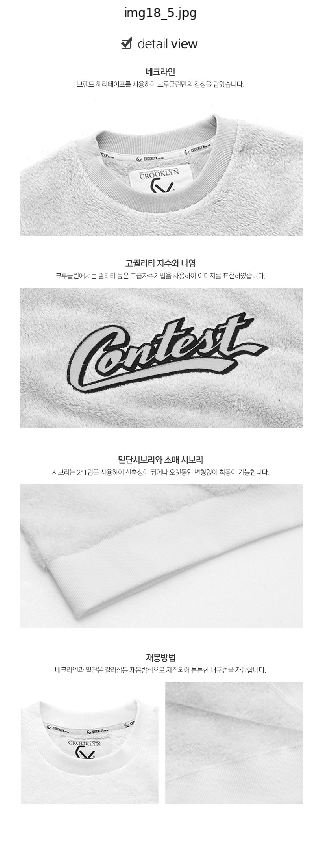

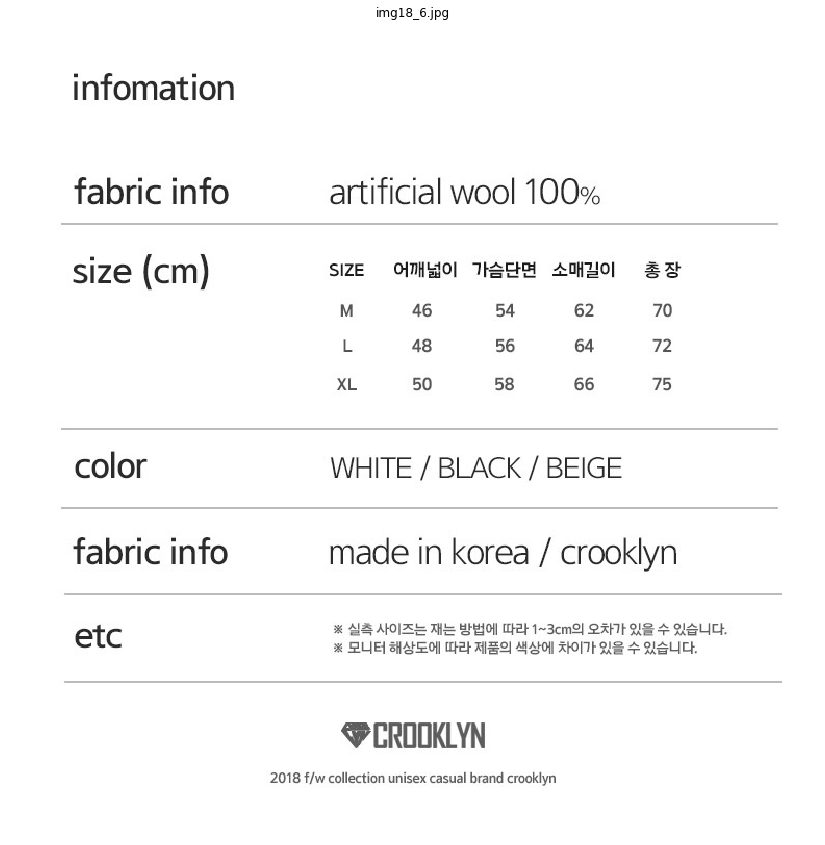

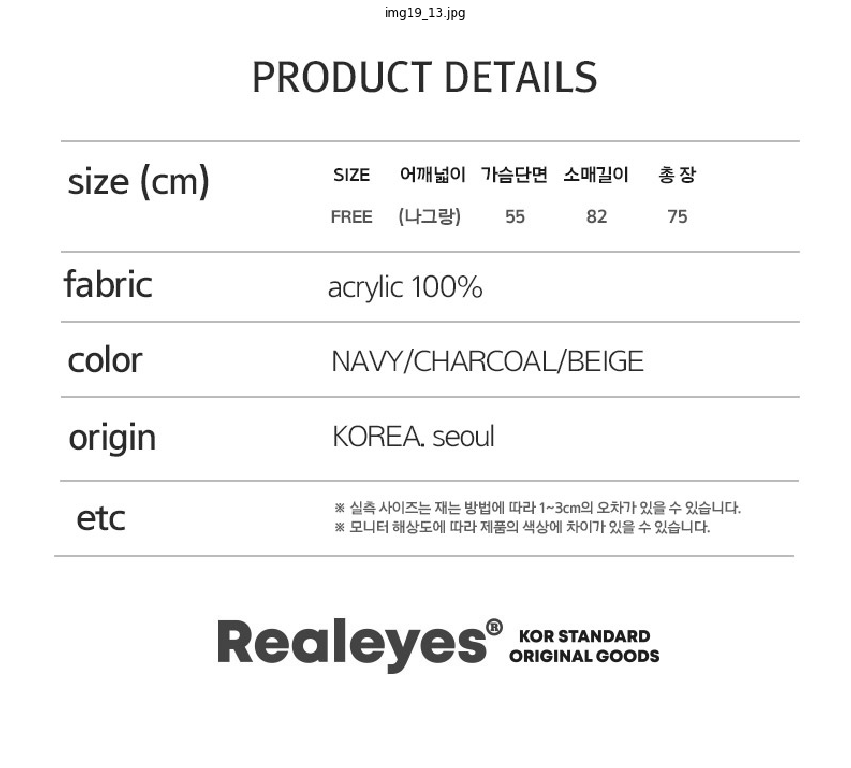

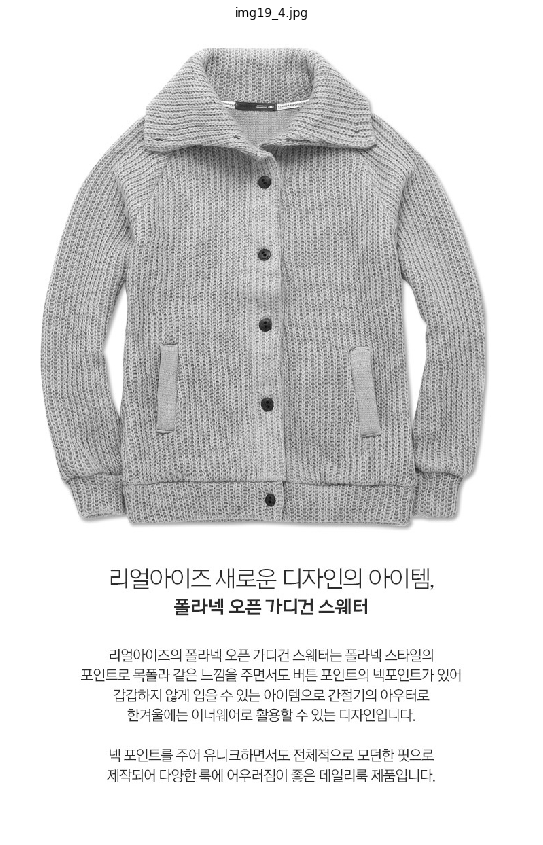

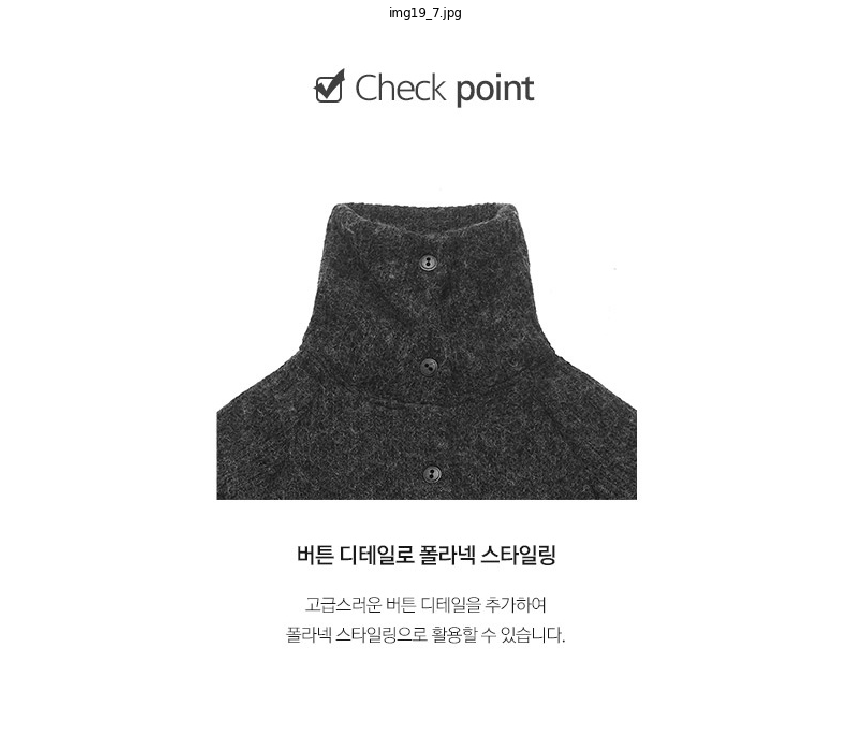

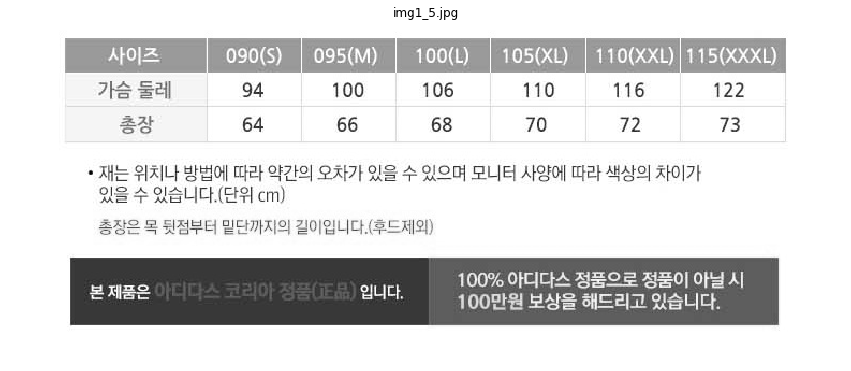

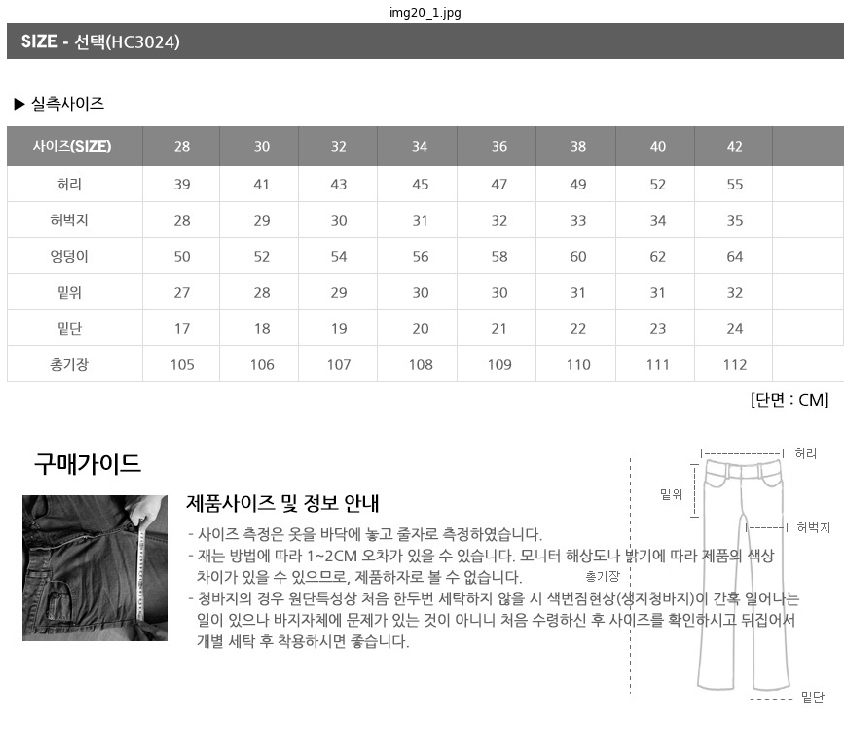

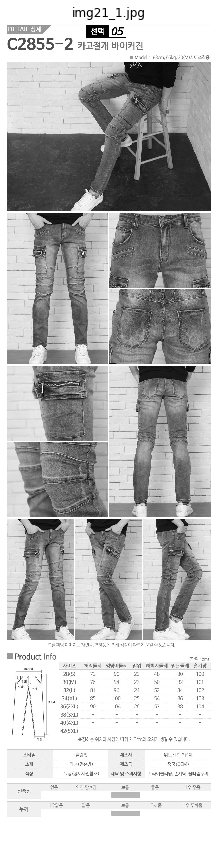

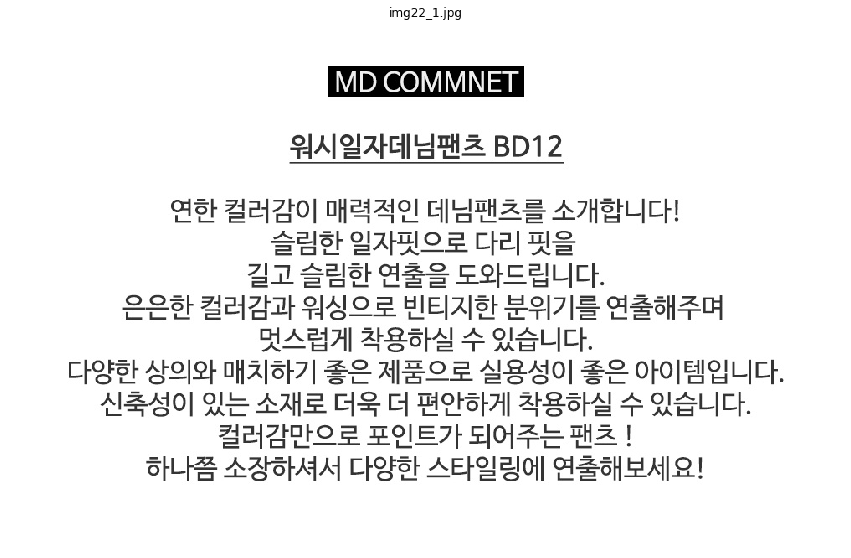

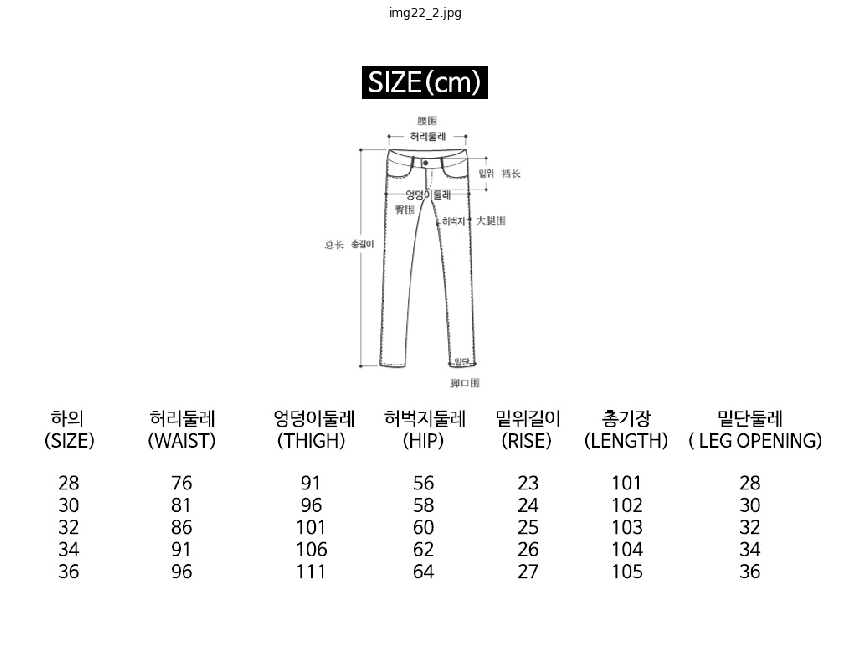

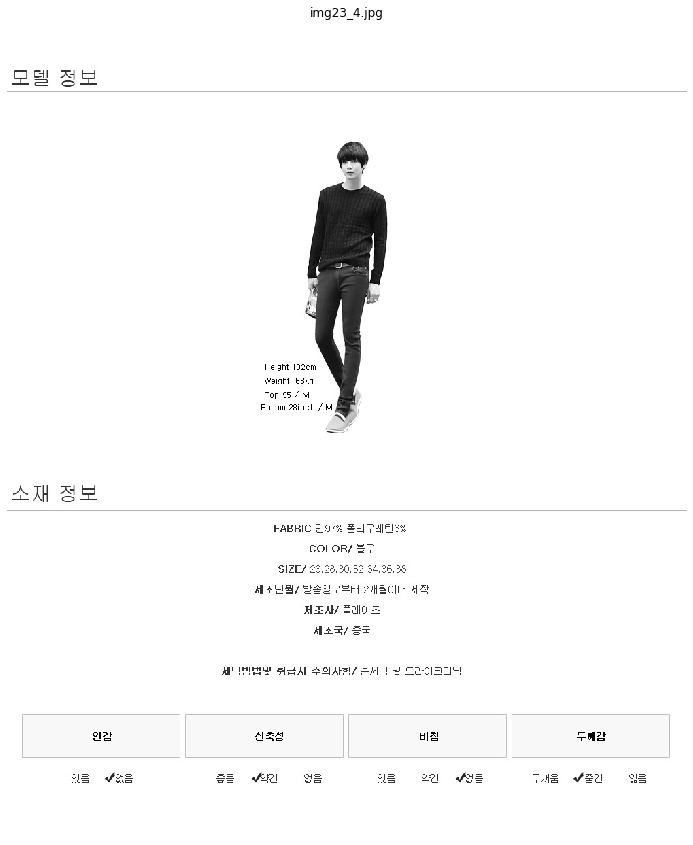

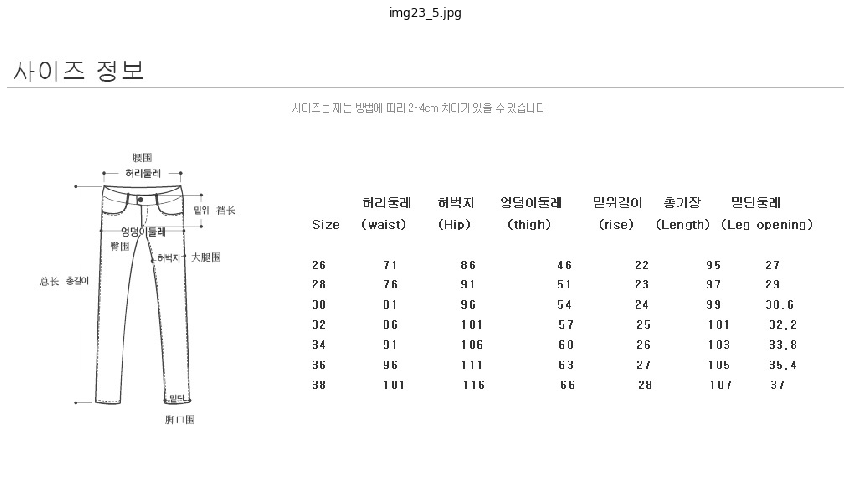

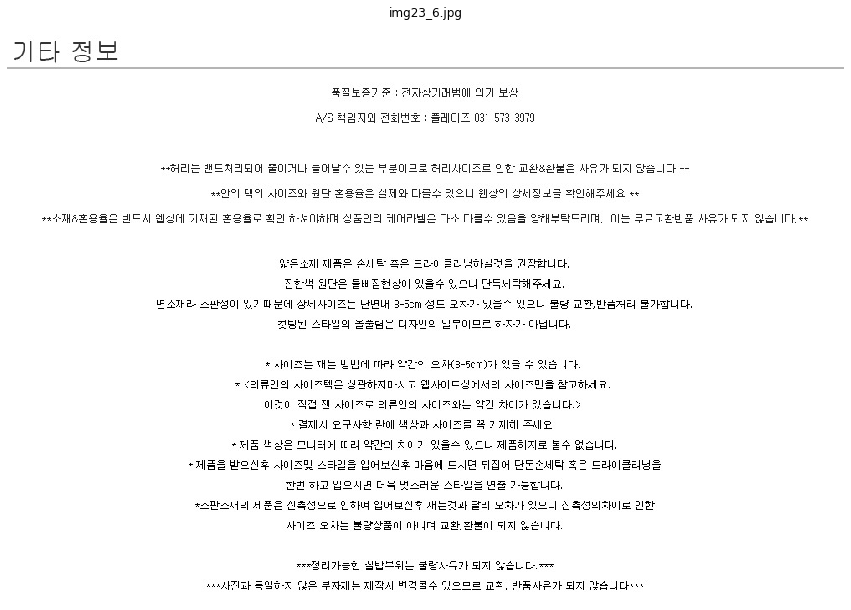

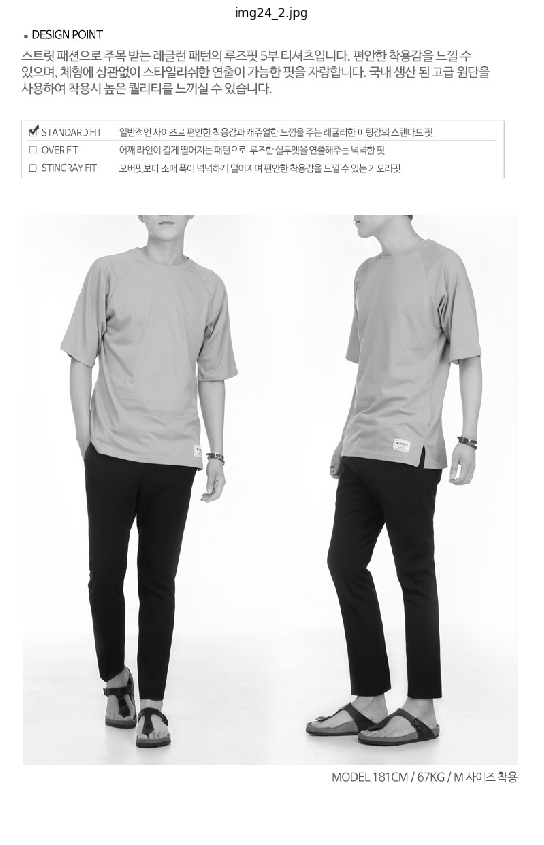

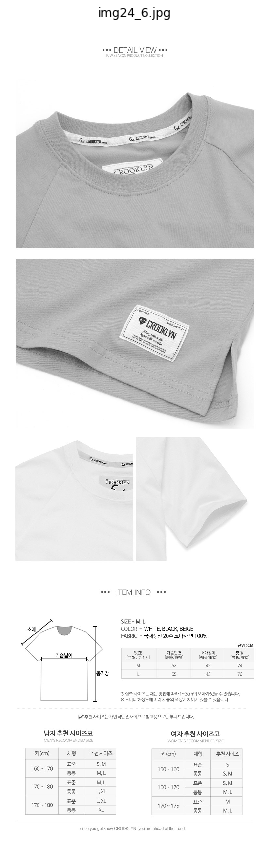

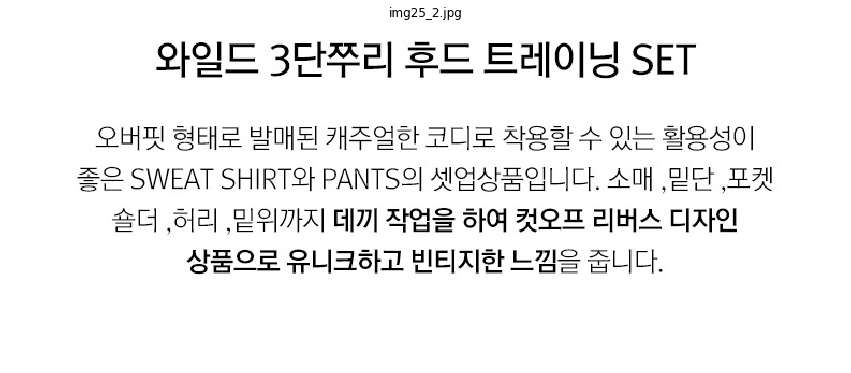

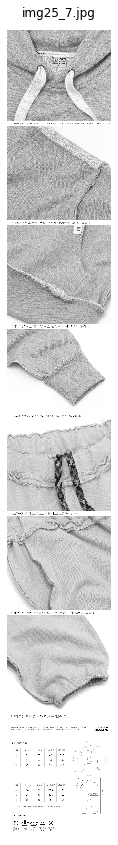

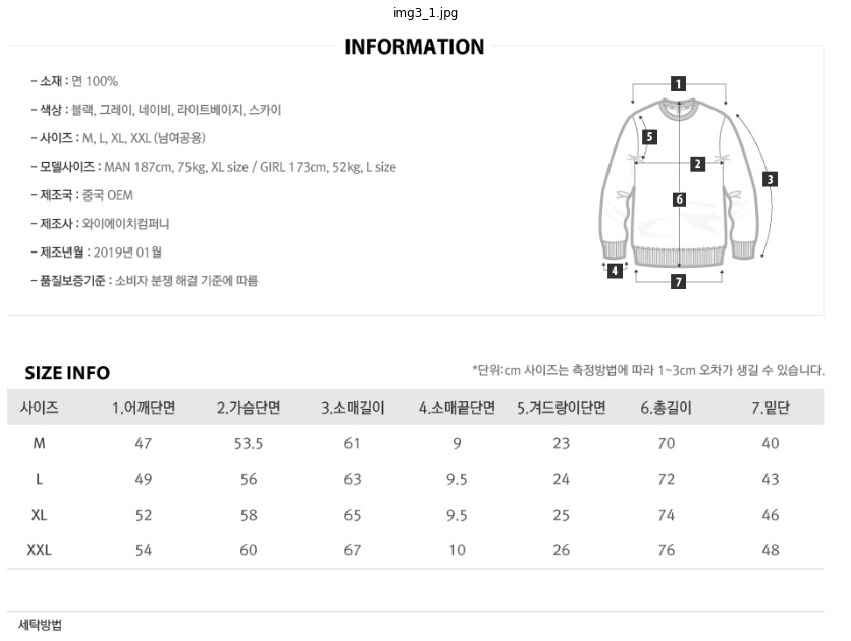

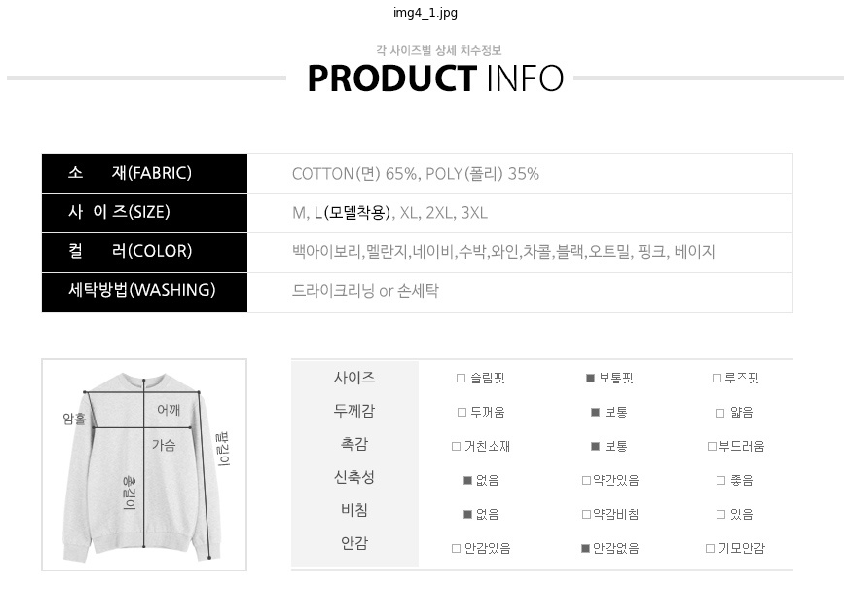

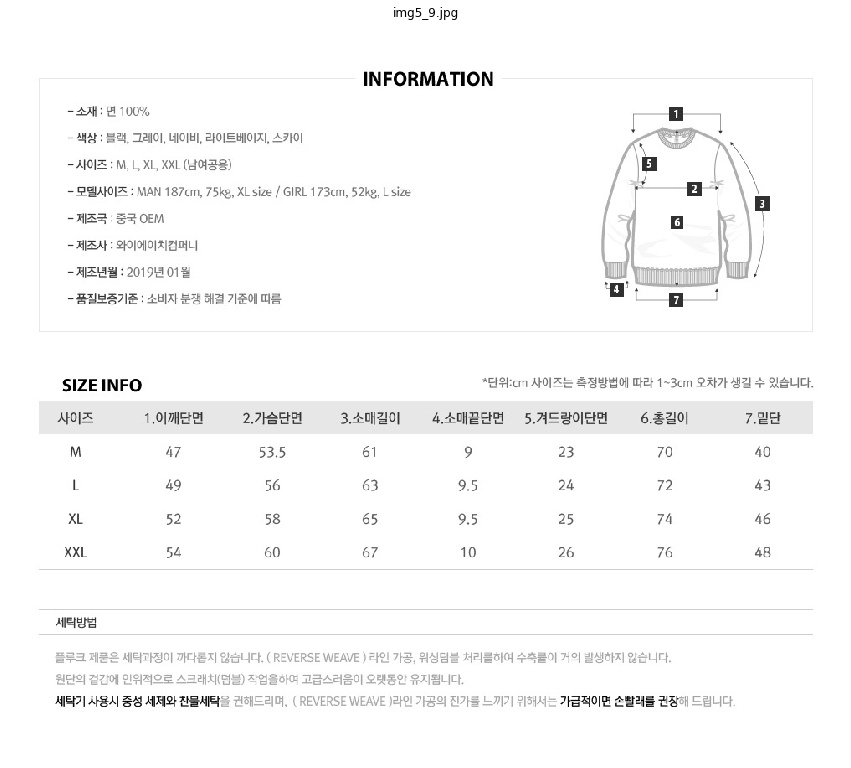

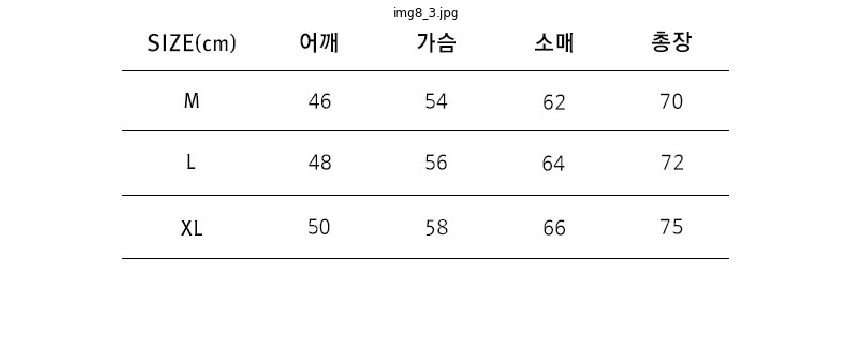

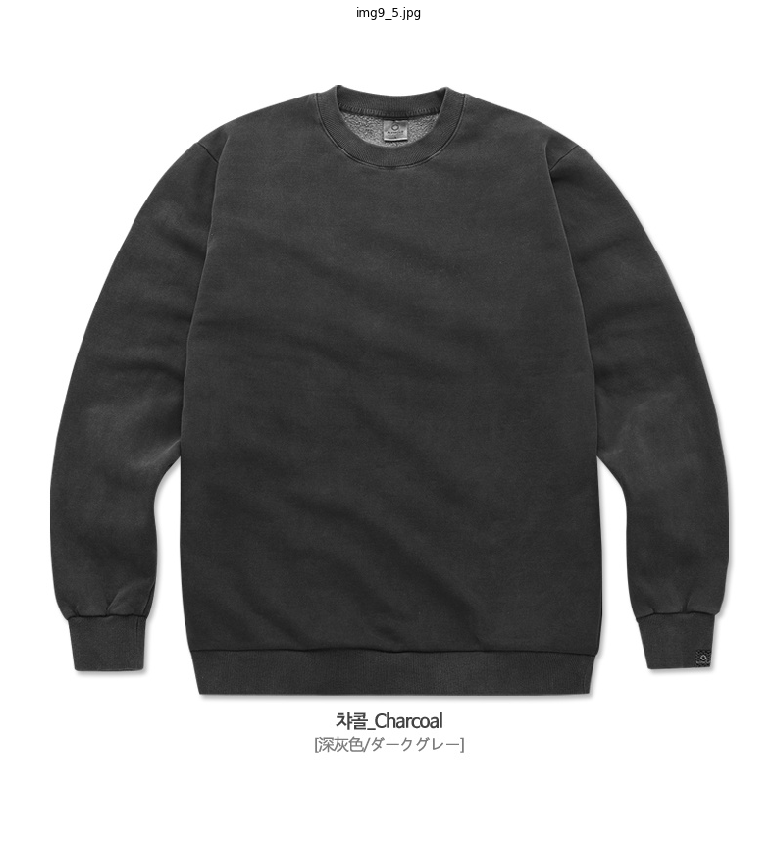

In [17]:
for img,idx in zip(predict_img, file_list):
    fig, axes = plt.subplots(1, 1, figsize=(15,15))
    plt.title(f'{idx}')
    axes.imshow(img)
    axes.axis('off')